In [1]:
import tellurium as te

In [2]:
# model from https://www.sciencedirect.com/science/article/pii/S0022519300921507
# time step is in days? G and I are in days at least.

r = te.loada("""
species $G; species $I; species $beta;

G' = R0 - (EG0 + SI*I)*G; // glucose concentration in blood (mg/dL)
I' = beta*sigma*G^2/(alpha + G^2) - k*I; // insulin concentration in blood
beta' = (-d0 + r1*G - r2*G^2)*beta; // beta cell mass

// parameters
SI = 0.72;
EG0 = 1.44;
R0 = 864;
sigma = 43.2;
alpha = 20000;
k = 432;
d0 = 0.06;
r1 = 0.84*10^(-3);
r2 = 0.24*10^(-5);

//initial values
beta = 300;
G = 100;
I = 0;

G is "blood glucose concentration (mg/dL)";
I is "blood insulin concentration (microU/mL)";
beta is "beta cell mass";
""")

In [3]:
result = r.simulate(0, 80)

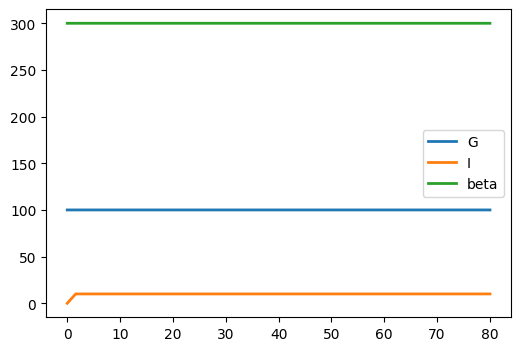

In [4]:
# physiological steady state: beta = 300, G = 100, I = 10
r.plot(result)

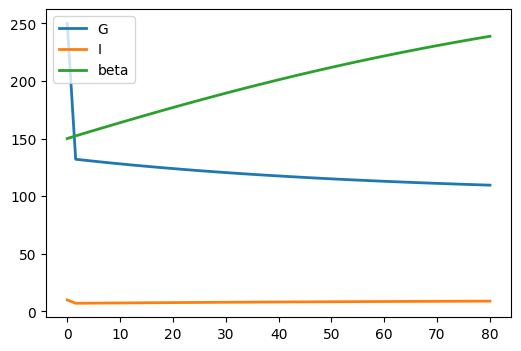

In [5]:
# Try some different values: G = 150?
r.setValue('G', 250)
r.setValue('beta', 150)
result = r.simulate(0, 80)
r.plot(result)

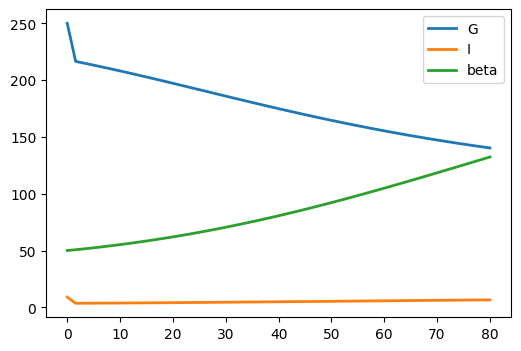

In [6]:
# Try some different values: G = 150?
r.setValue('G', 250)
r.setValue('beta', 50)
result = r.simulate(0, 80)
r.plot(result)

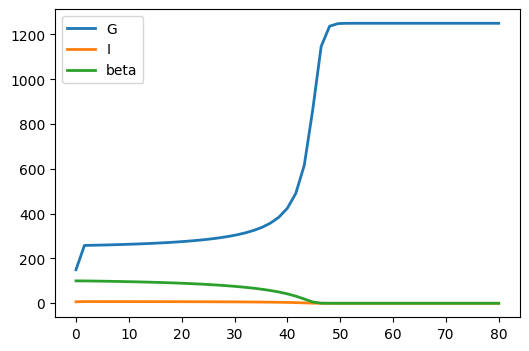

In [7]:
# Converging to pathological state - increasing daily net glucose production
r.setValue('G', 150)
r.setValue('beta', 100)
r.setValue('R0', 1800)
result = r.simulate(0, 80)
r.plot(result)

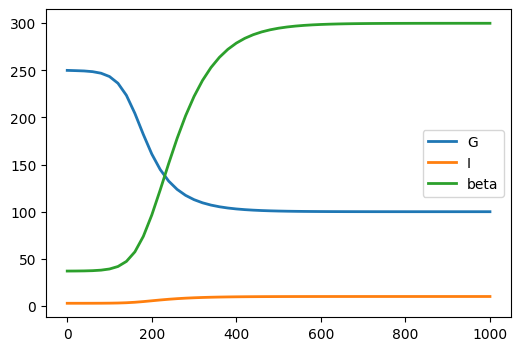

In [8]:
# saddle point
r.resetAll()
r.setValue('G', 250)
r.setValue('beta', 37)
r.setValue('I', 2.8)
result = r.simulate(0, 1000)
r.plot(result)

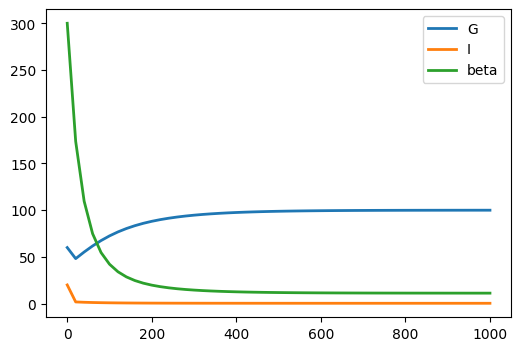

99.97099975948865


In [29]:
# saddle point
r.resetToOrigin()
r.setValue('G', 60)
r.setValue('I', 20)
r.setValue('SI', 1.5)
r.setValue('R0', 200)
result = r.simulate(0, 1000)
r.plot(result)
print(result['G'][-1])

## Parameter sensitivity estimates

Latin hypercube sampling?

In [9]:
print(r.getGlobalParameterValues())
print(r.getGlobalParameterIds())
print(r.getGlobalParameterByName('k'))

[8.64e+02 1.44e+00 7.20e-01 4.32e+01 2.00e+04 4.32e+02 6.00e-02 8.40e-04
 2.40e-06]
['R0', 'EG0', 'SI', 'sigma', 'alpha', 'k', 'd0', 'r1', 'r2']
432.0


In [10]:
r.setValue('R0', 864)

In [11]:
from scipy.stats import qmc
from scipy.stats.qmc import LatinHypercube

In [12]:
parameter_ranges = {#parameters
                    'SI': [0.1, 2],
                    'EG0': [0.1, 5],
                    'R0': [100, 2000],
                    'sigma': [20, 80],
                    'alpha': [10000, 40000],
                    'k': [200, 800],
                    'd0': [0.01, 0.1],
                    'r1': [0.1e-3, 0.1e-2],
                    'r2': [0.1e-6, 0.1e-4],
                    # initial conditions
                    'G': [50, 200],
                    'I': [0, 30],
                    'beta': [100, 500],
                   }
                    

In [13]:
sampler = LatinHypercube(len(parameter_ranges))

In [14]:
n_samples = 10
samples = sampler.random(n_samples)
all_param_vals = []
for i in range(n_samples):
    sample = samples[i]
    param_vals = {}
    r.resetToOrigin()
    for j, (param_id, param_range) in enumerate(parameter_ranges.items()):
        pv = sample[j]*(param_range[1] - param_range[0]) + param_range[0]
        r.setValue(param_id, pv)
        param_vals[param_id] = pv
    result = r.simulate(0, 1000)
    param_vals['G_final'] = result['G'][-1]
    param_vals['I_final'] = result['I'][-1]
    param_vals['beta_final'] = result['beta'][-1]
    print(param_vals)
    all_param_vals.append(param_vals)

Traceback (most recent call last):
  File "/tmp/ipykernel_1776/367216678.py", line 12, in <cell line: 4>
RuntimeError: Object of type <class 'NamedArray'> appears to be C subclassed NumPy array, void scalar, or allocated in a non-standard way.NumPy reserves the right to change the size of these structures. Projects are required to take this into account by either recompiling against a specific NumPy version or padding the struct and enforcing a maximum NumPy version.
Exception ignored in: 'PyDataMem_UserFREE'
Traceback (most recent call last):
  File "/tmp/ipykernel_1776/367216678.py", line 12, in <cell line: 4>
ValueError: PyCapsule_GetPointer called with invalid PyCapsule object
Traceback (most recent call last):
  File "/tmp/ipykernel_1776/367216678.py", line 12, in <cell line: 4>
RuntimeError: Object of type <class 'NamedArray'> appears to be C subclassed NumPy array, void scalar, or allocated in a non-standard way.NumPy reserves the right to change the size of these structures. Pr

{'SI': 0.6410046396751363, 'EG0': 2.632810089023718, 'R0': 1189.887120890659, 'sigma': 43.88088756202659, 'alpha': 17104.530704120218, 'k': 210.74135200210208, 'd0': 0.02495439390188195, 'r1': 0.0008538241320889076, 'r2': 5.83727824159687e-06, 'G': 171.786584287097, 'I': 25.05375803618933, 'beta': 151.36143459113924, 'G_final': 451.9456704649312, 'I_final': 7.206917537494112e-21, 'beta_final': 3.7222260049579327e-20}
{'SI': 1.0655826482016755, 'EG0': 0.4179948466417456, 'R0': 576.6286690862576, 'sigma': 57.448531289717835, 'alpha': 14792.653136335854, 'k': 357.25504069436704, 'd0': 0.08114707982179407, 'r1': 0.000466958065744952, 'r2': 9.276548292646691e-06, 'G': 84.67925672795869, 'I': 23.464283683551198, 'beta': 327.3882043343227, 'G_final': 1379.511430692942, 'I_final': 7.931930137189745e-25, 'beta_final': 4.079709320135288e-24}
{'SI': 1.8742826800955954, 'EG0': 1.9515005413689406, 'R0': 200.63817694888778, 'sigma': 72.58264277603516, 'alpha': 24504.57866330372, 'k': 757.35470580326

In [17]:
import pandas as pd

In [18]:
df = pd.DataFrame(all_param_vals)

In [19]:
df

,SI,EG0,R0,sigma,alpha,k,d0,r1,r2,G,I,beta,G_final,I_final,beta_final
0,0.641005,2.632810,1189.887121,43.880888,17104.530704,210.741352,0.024954,0.000854,5.837278e-06,171.786584,25.053758,151.361435,451.945670,7.206918e-21,3.722226e-20
1,1.065583,0.417995,576.628669,57.448531,14792.653136,357.255041,0.081147,0.000467,9.276548e-06,84.679257,23.464284,327.388204,1379.511431,7.931930e-25,4.079709e-24
2,1.874283,1.951501,200.638177,72.582643,24504.578663,757.354706,0.082132,0.000724,8.071946e-06,193.990110,28.453481,224.681703,102.812258,-6.898908e-16,-2.388354e-14
3,0.901310,1.017939,1478.601420,25.879021,33310.667369,447.616688,0.071389,0.000320,6.788164e-07,64.591317,8.710076,207.891530,1452.543888,-3.983836e-15,-6.983177e-14
4,1.300662,3.965863,1830.739769,76.993736,26668.650550,548.964395,0.097293,0.000204,1.653628e-06,78.690404,15.351006,398.092848,461.624539,-4.059139e-16,-3.254217e-15
5,0.831666,3.455196,1414.011432,52.729701,19084.895620,626.168860,0.014278,0.000572,6.813705e-06,136.362106,14.323631,270.731917,409.242067,-3.053724e-20,-4.035911e-19
6,0.332596,4.815797,741.823248,65.404792,38022.704586,317.866360,0.051931,0.000933,3.393989e-06,116.866058,3.470715,104.904951,77.492190,1.430288e+01,5.096466e+02
7,1.705466,2.284987,1776.780759,37.526332,28675.215931,574.014928,0.039591,0.000175,2.239663e-06,142.218337,19.527012,349.399023,777.588880,1.171546e-21,1.871243e-20
8,0.175658,4.198229,365.529436,26.314869,11975.263890,735.173417,0.060326,0.000432,4.531365e-06,165.262360,11.932327,464.164235,87.067534,-1.236472e-15,-8.910606e-14
9,1.490664,1.490814,909.580828,48.531173,36153.679659,422.403761,0.031774,0.000810,7.775308e-06,109.660431,1.755626,442.513357,610.123704,2.410428e-22,2.285765e-21
